# 2 Class Latent DIF Experimental Demonstration - Step-by-step explanation

### _An Introduction to Differential Item Functioning (DIF)_

_Setting_: A professor collects the exam papers that her students have taken. She has prepared an exam with varying levels of difficulty to test students' innate abilities. However, she does not know if some of the students who have the same underlying abilities underperform because of the placement of a question on the exam. If she places the trickier questions at the end of the exam paper, some students may struggle to perform to the best of their abilities because of time constraints. In order to identify students that may benefit from extra time, she decides to run a statistical study.

In the above scenario, each question on the exam is called an 'Item', the exam paper is an 'Instrument', a student's innate ability is a 'Latent Trait', and the group of students with the same innate ability who score differently forms the 'Latent Groups' or 'Latent Classes'. As latent traits and latent groups are unobservable, the use of an Instrument is essential to quantify traits and identify latent groups. Differential Item Functioning is the change in probability of success for a given item (scoring correctly on a question) resulting from a student belonging to a certain latent group.



### _The Experimental Study: Two Class Latent DIF_

In the scenario where we have two classes (latent groups), we run an experimental demonstration of the accuracy of our proposed model. The model is based on the following study: https://link.springer.com/article/10.1007/s11336-024-09948-7.

##### - _Two Parameter Item Response Model_

We assume the following model: $$\text{logit }P(Y_{ij}=1|\theta_i,\xi_i)=a_j\theta_i + d_j + \delta_{j,\xi_i}$$
where: $a_j$ is the discrimination parameter, $d_j$ is the easiness parameter (difficulty), 
$\delta_{j\xi_i}$ is the DIF effect parameter, and $a_j\theta_i+d_j$ is the item response function for the reference group for $\xi_i = 0$.

We assume that latent classes follow a categorical distribution, where $P(\xi_i=k)=v_k$ is the probability of belonging to a certain class. Using the Marginal Maximum Likelihood Estimation to isolate the latent ability $\theta_i$, the marginal likelihood function is: $$L(\Delta)=\prod^N_{i=0}\sum\limits^K_{k=0}v_k\int(\prod^J_{j=1}\frac{exp(a_j \theta + d_j + \delta_{jk})Y_{ij}}{1+exp(a_j\theta+d_j+\delta_{jk})})\phi(\theta|\mu_k,\sigma^2_k)d\theta$$

To estimate the unknown parameters $a_j,d_j,\delta_{jk},v_k,\mu_k,\sigma_k^2$, we need to establish anchor items (items that are not affected by DIF), thus we assume a sparsity pattern. That is, we assume that only some DIF effects will be statistically significant. 

### Testing Different parameters

To test the best and worst performing parameters, we test across number of items (J_total), number of DIF items (p: this is chosen as a fraction of the J_total), proportion of respondents in the outlier group (pi: a fraction of the number of total respondents).

We evaluate the difference between the estimated AUC and true AUC; the true AUC is the AUC based on the true model parameters, which allows us to compare how well the model classifies when the parameters are known. Overall, smaller differences denote the model's good performance , whereas larger differences indicate an underperformace (overfitting, underfitting). By categorising the difference, we find the best performing models for each item (dependent on their total number of items) by choosing the smallest MSE.

Once the best models have been determined, we run these models using different random seeds to test their reliability. Similarly, we find the worst models and test them across different random seeds.


## _Outline_
1. Model Algorithm
2. Model Evaluation
3. Sensitivity Analysis - Algorithm
4. Sensitivity Analysis - Results
5. Conclusion

# 1. Model Algorithm
The package invites users to simulate the study with 2 latent classes. It creates a baseline 'true' model with randomised initial variables and then tests the proposed model for accuracy against the baseline. The computation of the simulation is based on an EM algorithm that seeks to decrease the objective function overtime. The parameters available are: the number of respondents (`nrespondents`), the number of total items (`nitems`), the number of DIF items (`ndifitems`), the number of replications (`nreplications`), the threshold for the probability of success (`class_threshold`), the probability of belonging to the outlier group (`outlier_probability`), the step size for Gradient Descent within the EM algorithm (`step`), the maximum number of iterations (`max_iteration`), the change in objective value at the Line Search algorithm to stop the loop (`tolerance`) and the random seed to initialise the randomisation component (`seed`).

In [1]:
# importing package
from src.functions.difalgorithm import DIFAlgorithm
from src.utils.plots import Plot
from src.utils.compare import Compare

import numpy as np
import pandas as pd

### Components of the algorithm

#### _Static Functions_

These include smaller functions:
- `update_outlier(post)` which updates the probability of being to the outlier group based on the posterior probability calculated, 
- `soft_threshold(x, lambd)` which is our sparsity assumption; it sets small values to 0 and shrinks large values according to `lambd` (Lasso regularisation), 
- `roc_curve(class_assign, xi_vec, thresholds)` which calculates the False Positive Rate and True Positive Rate,
- `prob_calc` which applies the sigmoid function to retrieve a probability, 
- `log_calc` which calculates the log likelihood.

#### _Medium Sized Functions_

These include the functions:
- `prox_grad()` computes a step of the proximal gradient descent method,
- `llik()` computes the log-likelihood for both classes using the log-sum-exp trick to avoid overflow,
- `post_matr()` calculates the posterior probability matrix for each item and each class,
- `classify_respondents()` classifies each respondent based on the posterior probabilities.

#### _`line_search()` and `line_search_conf()` Functions_

To find the optimal step size for updating parameters, the `line_search()` and `line_search_conf()` functions calculate the log likelihood achieved using an initial step size. If that step size does not force the log likelihood to converge over a certain number of iterations, then the initial step size is halved, until the optimal step size is found.

#### _`update_para()` and `update_para_conf()` Functions_

These functions are used for updating the unknown parameters detailed in the introduction. First, the gradients of each parameter is computed, then using these gradients, we run the `line_search` functions, such that we find the optimal step size. Using the optimal step-size, we can then update the parameters optimally.

#### _`EM()` and `EM_conf()` Functions_

`EM` stands for Expectation-Maximising, and is a 2 step algorithm, that first computes the expectation function, then maximises that expectation function. It maximises the regularised marginal likelihood function and optimizes the constrained estimator for a given value of the regularisation parameter lambda. Besides initialisation (which includes setting the objective functions and updating the outlier probability), the Expectation step takes place before the first loop: this is where the posterior probabilities are calculated via `post_matr()`. In the Maximisation step, the outlier probability is updated again using the new probabilities, and incorporates a proximal gradient algorithm, with a line search procedure to select the step size. To make sure that the EM algorithm's output is stable, a convergence check is put in place in the following loop.

#### _`Run()` Function_

This function is the main loop that runs all of the functions defined above. The main variables and parameters such as `a_vec`, `d_vec`, `delta_vec`, `xi_vec`, `theta_vec` and `grid` and `weight` which are the points used for approximating integrals; these initialised variables are randomised for the most part. The main loop iterates over the number of replications (hyperparameter), initialises the variables, before running the EM function. Here, the BIC value is recorded and is meant to decrease at the end of the nested loop. The nested loop iterates over the different `lambda_vecs`: this variable is a sequence of regularisation parameters that control the sparsity of `delta_vec`. After iterating through all the available `lambda_vecs`, the lowest BIC chooses the best model for each replication and for a certain `lambda_vec`.

In [10]:
# Running the function
respondents = 50
items = 50
dif_items = 10
reps = 100
class_thresh = 0.5
outlier_prob = 0.4
step = 1 # default is 0.1
max_it = 100 # default is 100
tol = 1e-5 # default is 1e-6
seed = 77666 # default is 776155
auc, mse, bic = DIFAlgorithm(nrespondents=respondents,nitems=items,
                             ndifitems=dif_items,nreps=reps,class_threshold=class_thresh,
                             outlier_probability=outlier_prob, step=step, max_iteration=max_it,
                             tolerance=tol,seed=seed).run()

# 2. Model Evaluation

Running the function returns 3 outputs:
- AUC: This is the history of all False Positive Rates and True Positive Rates over all the iterations.
- MSE: This is the MSE of `a_vec`, `d_vec`, `delta_vec`, by item.
- BIC: This is the full history of all BIC values printed during the run.

Using the `Plot` method, we can visualise the results:

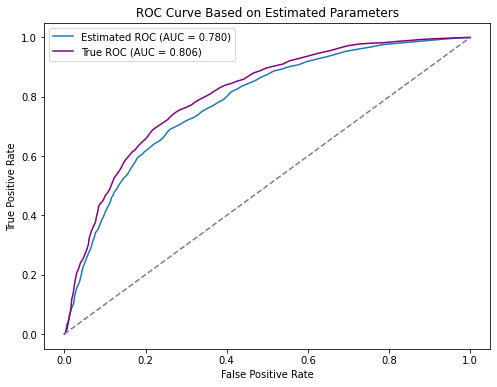

In [3]:
Plot().plot_auc(auc[0],auc[1])

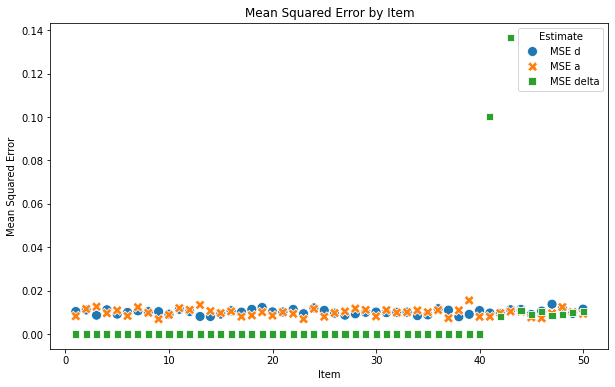

In [4]:
Plot().plot_MSE(Plot().get_df_MSE(mse))

# 3. Sensitivity Analysis - Algorithm

In this section, we evaluate the model's performance across different parameters. The package has a `Compare()` method, which allows users to choose the parameters for comparison.

The `Compare()` methods offers the following functions:
- `main()`: a function that runs the DIF algorithm using parallel processing for multiple sequential runs.
- `evaluate_best()`: a function that finds the best combinations of parameters (total item, DIF items, outlier probability)
- `evaluate_worst()`: a function that finds the worst combinations of parameters (total item, DIF items, outlier probability)
- `test_seeds()`: a function that tests different seeds

The following variables are iterated for the following values:
- _j_ (total number of items): 10, 100, 150, 200
- _p_ (number of DIF items, as a proportion of the total Items): 0.15, 0.3, 0.45, 0.6, 0.75, 0.9
- _pi_ (proportion of respondents belonging to the outlier group): 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5

_NOTE_

The code below has a long run time due to the amount of runs needed. For faster runtime, `pi_list`, `j_list`, `p_list`, `nrespondents` and `nreplications` can be shortened or reduced.

Because the speed of the algorithm decreases when run on a jupyter notebook, the `Compare().main()` function has been run on the `main.py` file, where the results have been outputted in csv format.

In [4]:
# Setting up parameters for comparison
n = 1000
n_replications = 50
class_threshold = 0.5
max_iter = 100
tol = 1e-6
pi_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
j_list = [10, 100, 150, 200]
p_list = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]

# Change parameter length or run the following in a .py file
results = Compare(nrespondents=n,nreps=n_replications,class_threshold=class_threshold,max_iteration=max_iter,
                   tolerance=tol,pi_list=pi_list,j_list=j_list,p_list=p_list).main()

Here we pull the results that were saved into a csv file.

In [2]:
# Reading results
results = pd.read_csv('Comparison_results.csv')
results.head()

,Item,MSE d,MSE a,MSE delta,Pi,P,AUC true,AUC est,J_total
0,1,0.006923,0.009818,0.0,0.05,2,0.677069,0.566236,10
1,2,0.008588,0.010475,0.0,0.05,2,0.677069,0.566236,10
2,3,0.008169,0.007239,0.0,0.05,2,0.677069,0.566236,10
3,4,0.008106,0.009120,0.0,0.05,2,0.677069,0.566236,10
4,5,0.008999,0.012222,0.0,0.05,2,0.677069,0.566236,10


The results are a compilation of the MSEs of variables a, d and delta, assigned to each item. The AUC est and AUC true are the average AUC estimated at the end of each run. 

We then run the following algorithm to select the best and worst performing models. The `evaluate_best()` and `evaluate_worst()` functions filters by the smallest difference between the estimated AUC and true AUC for each J_total.

We set a threshold to check the smallest AUC differences and the largest AUC differences from the results.

In [39]:
top_10 = Compare(nrespondents=n,nreps=n_replications,class_threshold=class_threshold,max_iteration=max_iter,
                   tolerance=tol,pi_list=pi_list,j_list=j_list,p_list=p_list).evaluate_best(results,0.01)

worst_10 = Compare(nrespondents=n,nreps=n_replications,class_threshold=class_threshold,max_iteration=max_iter,
                   tolerance=tol,pi_list=pi_list,j_list=j_list,p_list=p_list).evaluate_worst(results,0.05)

We can then test the reliabiity of the model across different seeds. Using a random number generator, we choose five different seeds.

In [10]:
np.random.seed(1156780)
seeds = np.random.uniform(100,1000000,5).astype(int).tolist()

results_best = Compare(nrespondents=10,nreps=10,class_threshold=class_threshold,max_iteration=max_iter,
                   tolerance=tol,pi_list=pi_list,j_list=j_list,p_list=p_list).test_seeds(top_10,seeds)

results_worst = Compare(nrespondents=10,nreps=10,class_threshold=class_threshold,max_iteration=max_iter,
                   tolerance=tol,pi_list=pi_list,j_list=j_list,p_list=p_list).test_seeds(worst_10,seeds)

970074 0
Running loop 0 of 10
Running 1 Lambda Loop of 10: BIC inf and BIC New 2332.307672803949
Running 2 Lambda Loop of 10: BIC 2332.307672803949 and BIC New 2332.3076707537875
Running 3 Lambda Loop of 10: BIC 2332.3076707537875 and BIC New 2332.3076687038565
Running 4 Lambda Loop of 10: BIC 2332.3076687038565 and BIC New 2332.3076666541556
Running 5 Lambda Loop of 10: BIC 2332.3076666541556 and BIC New 2332.307664604685
Running 6 Lambda Loop of 10: BIC 2332.307664604685 and BIC New 2332.3076625554454
Running 7 Lambda Loop of 10: BIC 2332.3076625554454 and BIC New 2332.3076605064357
Running 8 Lambda Loop of 10: BIC 2332.3076605064357 and BIC New 2332.307658457657
Running 9 Lambda Loop of 10: BIC 2332.307658457657 and BIC New 2332.307656409109
...

# 4. Sensitivity Analysis - Results

Now that all the different model parameters have been tested, we can review the results.

In [6]:
top_10

,Pi,J_total,AUC est,AUC true,P,AUC diff
0,0.45,150,0.966640,0.967891,45,0.001251
1,0.40,200,0.986156,0.987654,90,0.001498
2,0.25,200,0.985932,0.987502,90,0.001570
3,0.40,200,0.978158,0.979742,60,0.001584
4,0.35,200,0.985615,0.987213,90,0.001598
5,0.50,200,0.985592,0.987204,90,0.001612
6,0.30,200,0.977734,0.979351,60,0.001617
7,0.30,200,0.986347,0.987999,90,0.001652
8,0.50,150,0.965576,0.967237,45,0.001661
9,0.40,200,0.988693,0.990424,120,0.001731


In [40]:
worst_10

,Pi,J_total,AUC est,AUC true,P,AUC diff
0,0.05,10,0.566236,0.677069,2,0.110833
1,0.05,10,0.633098,0.742301,4,0.109203
2,0.05,10,0.609437,0.707779,3,0.098342
3,0.05,10,0.623271,0.714004,8,0.090733
4,0.05,10,0.634018,0.703190,6,0.069172
5,0.10,10,0.652029,0.719988,3,0.067959
6,0.05,10,0.666042,0.726620,9,0.060578
7,0.10,10,0.626548,0.682644,2,0.056096
8,0.15,10,0.646305,0.701030,3,0.054725
9,0.10,10,0.694279,0.747525,6,0.053246


The best performing parameters show an AUC difference of around 0.1%, and feature high outlier probabilities (0.3-0.5), with high numbers of items (150 & 200). However, the number of DIF items (P) are limited to less than 50% of the total number of items. The worst performing parameters show an AUC difference of 6% to 11%, and they all feature low total items (10 items) and low outlier probabilities (0.05-0.15).

We can select the best and worst models and view their performance using the plotting functions.

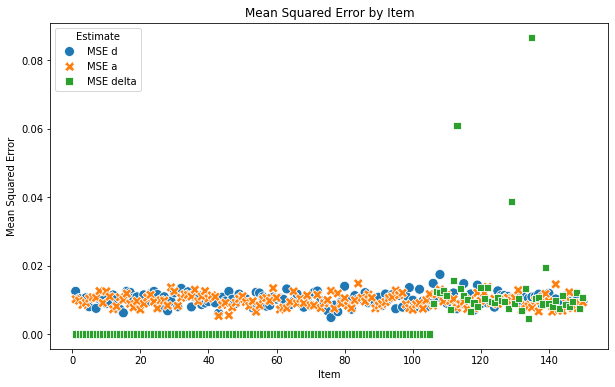

In [8]:
best_model_pi = top_10.loc[0,'Pi']
best_model_j = top_10.loc[0,'J_total']
best_model_p = top_10.loc[0,'P']
best_model = results[(results['J_total'] == best_model_j) & (results['P'] == best_model_p) & (results['Pi'] == best_model_pi)]
Plot().plot_MSE(best_model[['Item','MSE d','MSE a', 'MSE delta']])

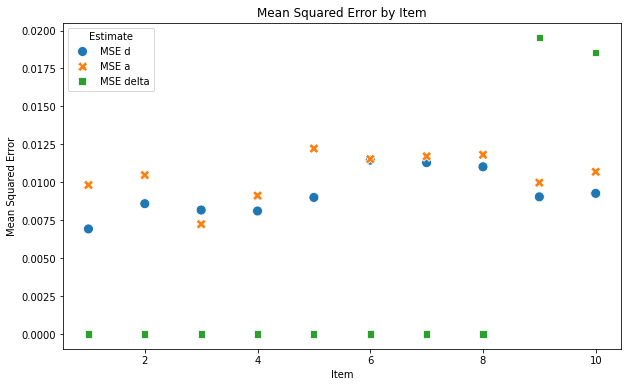

In [9]:
worst_model_pi = worst_10.loc[0,'Pi']
worst_model_j = worst_10.loc[0,'J_total']
worst_model_p = worst_10.loc[0,'P']
worst_model = results[(results['J_total'] == worst_model_j) & (results['P'] == worst_model_p) & (results['Pi'] == worst_model_pi)]
Plot().plot_MSE(worst_model[['Item','MSE d','MSE a', 'MSE delta']])

### Classification Error (AUC) of Respondents

As highlighted in the study by Wallin et al. (https://link.springer.com/article/10.1007/s11336-024-09948-7), the TPR is higher when the number of items is larger, that is the classification of DIF items is more accurate when the item size is larger. Classification accuracy is only 0.1% worse than the true model in such cases. The best parameters result in high true AUC and est AUC (around 0.9) whereas the worst parameters present lower AUC in general (between 0.5-0.7). 


### Accuracy of Item Classification

As we can see, the MSE for the best model ranges between 0.00 and 0.08 whereas the MSE for the worst model ranges between 0.00 and 0.02. As shown by the low MSE across even the worst performing and best performing models, the DIF items are identified correctly, with the exception of a few DIF items towards the end of the items, although they are still low.


### Hyperparameter Evaluation

The worst parameters are the ones that have low item size and small outlier probability, as compared to the best parameters which feature a large item size and large outlier probability. Because the outlier probability defines the probability of respondents belonging to a group affected by DIF items, if the outlier probability is low, then the model may overfit and assume that respondents who do belong to the outlier group are in fact part of the base group. With lower item sizes, it only becomes more difficult to identify respondents correctly. 

In [24]:
results_best.head()

,Item,MSE d,MSE a,MSE delta,Pi,P,AUC est,AUC true,J_total,Seed,AUC Diff
0,1,0.006726,0.007968,0.0,0.45,45,0.945833,0.953125,150,970074,0.007292
1,2,0.011301,0.010352,0.0,0.45,45,0.945833,0.953125,150,970074,0.007292
2,3,0.012694,0.008684,0.0,0.45,45,0.945833,0.953125,150,970074,0.007292
3,4,0.006109,0.008450,0.0,0.45,45,0.945833,0.953125,150,970074,0.007292
4,5,0.006620,0.015945,0.0,0.45,45,0.945833,0.953125,150,970074,0.007292


In [31]:
results_best['AUC Diff'] = results_best['AUC true'] - results_best['AUC est']
results_best.groupby(['Pi','J_total','P']).mean().reset_index(drop=False)

,Pi,J_total,P,Item,MSE d,MSE a,MSE delta,AUC est,AUC true,Seed,AUC Diff
0,0.25,200,90,100.5,0.009912,0.010105,0.008175,0.990790,0.994341,601896.4,0.003551
1,0.30,200,60,100.5,0.009845,0.010184,0.005691,0.965909,0.974247,601896.4,0.008338
2,0.30,200,90,100.5,0.009895,0.010121,0.008237,0.993179,0.995211,601896.4,0.002032
3,0.35,200,90,100.5,0.009897,0.010129,0.008636,0.992503,0.994463,601896.4,0.001960
4,0.40,200,60,100.5,0.009832,0.010187,0.006017,0.944339,0.969548,601896.4,0.025208
5,0.40,200,90,100.5,0.009897,0.010129,0.008636,0.984862,0.988647,601896.4,0.003784
6,0.40,200,120,100.5,0.009948,0.010163,0.012310,0.981147,0.989961,601896.4,0.008814
7,0.45,150,45,75.5,0.009932,0.010018,0.007066,0.936025,0.945952,601896.4,0.009927
8,0.50,150,45,75.5,0.009922,0.010029,0.006872,0.940735,0.955602,601896.4,0.014867
9,0.50,200,90,100.5,0.009889,0.010145,0.008649,0.988637,0.993143,601896.4,0.004506


In [34]:
results_worst['AUC Diff'] = results_worst['AUC true'] - results_worst['AUC est']
results_worst.groupby(['Pi','J_total','P']).mean().reset_index(drop=False)

,Pi,J_total,P,Item,MSE d,MSE a,MSE delta,AUC est,AUC true,Seed,AUC Diff
0,0.05,10,2,5.5,0.010798,0.010979,0.003348,0.207111,0.205000,601896.4,-0.002111
1,0.05,10,3,5.5,0.010368,0.011006,0.004557,0.126333,0.172222,601896.4,0.045889
2,0.05,10,4,5.5,0.011318,0.010971,0.008072,0.108444,0.125000,601896.4,0.016556
3,0.05,10,6,5.5,0.010054,0.010992,0.010392,0.201444,0.221333,601896.4,0.019889
4,0.05,10,8,5.5,0.010306,0.010419,0.012734,0.418000,0.573333,601896.4,0.155333
5,0.05,10,9,5.5,0.010548,0.010069,0.013901,0.355000,0.489889,601896.4,0.134889
6,0.10,10,2,5.5,0.010419,0.011195,0.003615,0.558708,0.746097,601896.4,0.187389
7,0.10,10,3,5.5,0.010246,0.011036,0.004687,0.586299,0.756951,601896.4,0.170653
8,0.10,10,6,5.5,0.010182,0.010424,0.016484,0.609021,0.749182,601896.4,0.140161
9,0.15,10,3,5.5,0.010227,0.010939,0.004023,0.602995,0.764377,601896.4,0.161382


### Reliability (Seeds)

As shown by the results from the seeds, the average AUC difference for each of the best models ranges between 0.1% and 2% and the AUC difference for each of the worst models ranges from -0.2% to 18%. What we can understand from these results is that the model can overfit at times, especially when the parameters are not well chosen (small number of items and small outlier probability). The MSEs for a, d and delta range respectively around 0.01 (best and worst), around 0.009 (best) and around 0.01 (worst), and 0.06-0.01 (best) and 0.003-0.013 (worst). These MSEs are small and are stable across ill-chosen and well-chosen parameters. On the other hand the true AUC's lowest can be worse than random for the worst parameters (0.1-0.4). Some of the AUC deltas are even negative which suggest severe overfitting.

Across seeds, we can draw an understanding that parameters have a huge effect on the results of the simulation even across multiple seeds. The most important hyperparameter is the size of the items; when the size is low, the model is likely to overfit, and this is especially exacerbated when the outlier probability is low as well. In turn, when the number of total items is high, the model's average true AUC is much higher, with smaller differences between the estimated and true AUC. Hence classification error low when item number is high. 

# 5. Conclusion

This package is destined for those wishing to simulate the performance of the hybrid latent DIF model for 2 classes. The sensitivity analysis across the parameters such as total item size, DIF item size and outlier probability shows that larger item sizes paired with higher outlier probability perform better overall compared to lower item size and outlier probability. 

Future updates will include: the ability to change the number of classes, more comparison methods, and more comparisons between different parameters (number of respondents and number of replications)